In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
# keras bult in IMDb dataset
# set vocab size and keep only this many frequent words
vocab_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

17464789/17464789 [==============================] - 1s 0us/step


In [3]:
# print out training and testing data that was loaded
# 25000 training samples
# 12500 positive samples
# 25000 test samples
print('Number of training samples: ', len(y_train))
print('Number of positive samples:', sum(y_train))
print('Number of test samples:', len(y_test))

Number of training samples:  25000
Number of positive samples: 12500
Number of test samples: 25000


In [4]:
# print training sample
# each word represented by an integer
# integer value indicates frequency of the word
print(X_train[0])
# use word dictionary to map integer to word
word_index = imdb.get_word_index()
index_word = {index: word for word, index in word_index.items()}
print([index_word.get(i, ' ') for i in X_train[0]])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1641221/1641221 [==============================] - 1s 0us/step
['the', 'as'

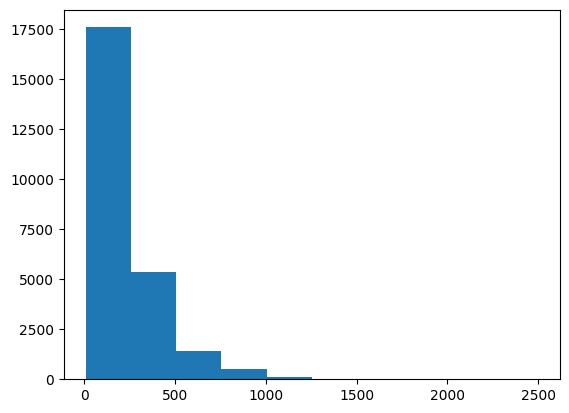

In [5]:
# analyze length of each sample
# all input sequences to RNN must be of same length
review_lengths = [len(x) for x in X_train]
# plot distribution of document lengths

#
#
#
# noted out to prevent double plots
plt.hist(review_lengths, bins=10)
plt.show()

In [6]:
# majority of reviews around 200 words long
# set 200 as universal sequence length
# pad shorter reviews with zeros and cutting longer reviews
# use pad_sequences from keras
maxlen = 200
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
# print out input sequences
print('X_train shape after padding:', X_train.shape)
print('X_test shape after padding:', X_test.shape)

X_train shape after padding: (25000, 200)
X_test shape after padding: (25000, 200)


**2. Developing a LSTM network**

In [7]:
# building LSTM netwrok
# training and testing datasets ready, RNN can be built
# fix random seed and initiate keras sequential model
tf.random.set_seed(42)
model = models.Sequential()

In [8]:
# input sequences are encoded vectors
# need to be changed to dense vectors using embedding layer from keras
# input sequences made of vocab_size=5000 unique word tokens into
# dense vectors of size 32
embedding_size = 32
model.add(layers.Embedding(vocab_size, embedding_size))


In [9]:
# recurrent LSTM layer
# single layer with 50 nodes
# output layer with sigmoid activation function
# because binary classification
model.add(layers.LSTM(50))
model.add(layers.Dense(1, activation='sigmoid'))
# display model summary to double check layers
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160000    
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 176,651
Trainable params: 176,651
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# compile model with Adam optimizer
# use binary cross-entropy as optimaztion target
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [11]:
# train model with batches of 64 size for three epochs
batch_size = 64
n_epoch = 3
model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epoch, validation_data=(X_test, y_test))

Epoch 1/3
391/391 [==============================] - 110s 272ms/step - loss: 0.4201 - accuracy: 0.7981 - val_loss: 0.3185 - val_accuracy: 0.8672
Epoch 2/3
391/391 [==============================] - 85s 217ms/step - loss: 0.2581 - accuracy: 0.8959 - val_loss: 0.3188 - val_accuracy: 0.8685
Epoch 3/3
391/391 [==============================] - 85s 218ms/step - loss: 0.2206 - accuracy: 0.9130 - val_loss: 0.3183 - val_accuracy: 0.8705


In [12]:
# evaluate classification accuracy on testing set
acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy:', acc)

Test accuracy: 0.8705199956893921


**3. Boosting the performance with multiple LSTM layers**

In [13]:
#
#
#
# boost perfromance with multiple LSTM layers
# stack two recurrent layers
# new model and add embedding layer, two LSTM layers and output layer
model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_size))
# first layer returns sequences to feed output into second layer
# 20% dropout to both LSTM layers to reduce overfitting
# due to more parameters to train
model.add(layers.LSTM(50, return_sequences=True, dropout=0.2))
model.add(layers.LSTM(50, dropout=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
# print model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          160000    
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          16600     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 196,851
Trainable params: 196,851
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Adam optimizer
optimizer = optimizers.Adam(lr=0.003)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])


In [16]:
# train stacked model for 7 epochs
n_epoch = 7
model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epoch,
          validation_data=(X_test, y_test))

Epoch 1/7
391/391 [==============================] - 181s 450ms/step - loss: 0.4332 - accuracy: 0.7884 - val_loss: 0.3245 - val_accuracy: 0.8616
Epoch 2/7
391/391 [==============================] - 173s 443ms/step - loss: 0.2776 - accuracy: 0.8886 - val_loss: 0.3180 - val_accuracy: 0.8656
Epoch 3/7
391/391 [==============================] - 174s 446ms/step - loss: 0.2399 - accuracy: 0.9067 - val_loss: 0.3270 - val_accuracy: 0.8675
Epoch 4/7
391/391 [==============================] - 168s 431ms/step - loss: 0.2164 - accuracy: 0.9165 - val_loss: 0.3692 - val_accuracy: 0.8436
Epoch 5/7
391/391 [==============================] - 174s 447ms/step - loss: 0.1966 - accuracy: 0.9247 - val_loss: 0.3521 - val_accuracy: 0.8655
Epoch 6/7
391/391 [==============================] - 174s 444ms/step - loss: 0.1745 - accuracy: 0.9324 - val_loss: 0.3384 - val_accuracy: 0.8676
Epoch 7/7
391/391 [==============================] - 174s 446ms/step - loss: 0.1414 - accuracy: 0.9488 - val_loss: 0.4349 - val_ac

In [17]:
# verify test accuracy
acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy with stacked LSTM:', acc)

#
#
#

Test accuracy with stacked LSTM: 0.8599200248718262


In [18]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

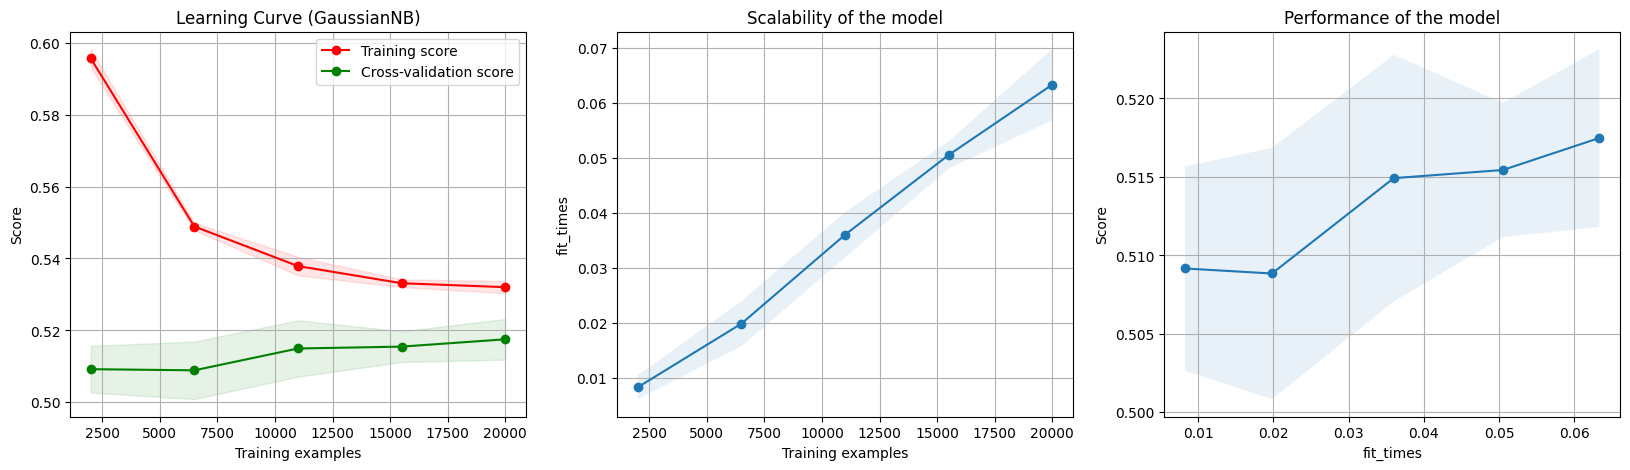

In [19]:
estimator = GaussianNB(var_smoothing=1e-09)
# call plot_learning_curve
x = plot_learning_curve(estimator, "Learning Curve (GaussianNB)", X_train, y_train)
x.show()